In [1]:
from pyomo.contrib.sensitivity_toolbox.sens import get_dsdp
import pyomo.environ as pyo
from RPB_model import *
import pickle

In [2]:
parameter = {
    "DmCO2": 5.3e-5, 
    "C1": 2.562434e-12, 
    "hgx": 25 * 1e-3, 
    "Cp_sol": 1.457, 
    "rho_sol": 1144, 
    "delH_1": 98.76,
    "delH_2": 77.11, 
    "delH_3": 21.25
}

#step = 0.001

#parameter['delH_1'] = 10000
#parameter["delH_2"] *= (1+step)

In [3]:
RPB = ConcreteModel()

RPB.ads = RPB_model(mode="adsorption", kaug=False, param_perturb=parameter)
RPB.des = RPB_model(mode="desorption", kaug=False, param_perturb=parameter)
#RPB.ads = RPB_model(mode="adsorption", kaug=True, param_perturb=parameter)
#RPB.des = RPB_model(mode="desorption", kaug=True, param_perturb=parameter)

In [4]:
# fix BCs
RPB.ads.P_in.fix(1.1)
RPB.ads.Tg_in.fix()
RPB.ads.y_in.fix()
RPB.ads.P_out.fix(1.01325)

RPB.des.P_in.fix(1.1)
RPB.des.Tg_in.fix()
RPB.des.y_in.fix()
RPB.des.P_out.fix(1.01325)

In [5]:
# connect rich stream
# unfix inlet loading and temperature to the desorption section. (No mass transfer at boundaries so z=0 and z=1 need to remain fixed.)
for z in RPB.des.z:
    if z!=0 and z!=1:
        RPB.des.qCO2_in[z].unfix()
        RPB.des.Ts_in[z].unfix()

# add equality constraint equating inlet desorption loading to outlet adsorption loading. Same for temperature.
@RPB.Constraint(RPB.des.z)
def rich_loading_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return RPB.des.qCO2_in[z] == RPB.ads.qCO2[z,1]

@RPB.Constraint(RPB.des.z)
def rich_temp_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return 1e-2*RPB.des.Ts_in[z] == 1e-2*RPB.ads.Ts[z,1]

In [6]:
# connect lean stream
# unfix inlet loading to the adsorption section
for z in RPB.ads.z:
    if z!=0 and z!=1:
        RPB.ads.qCO2_in[z].unfix()

# add equality constraint equating inlet adsorption loading to outlet desorption loading
@RPB.Constraint(RPB.ads.z)
def lean_loading_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return RPB.des.qCO2[z,1] == RPB.ads.qCO2_in[z]

In [7]:
# create Block init object
init_obj = BlockTriangularizationInitializer()

init_obj.config.block_solver_call_options = {"tee": True}
# init_obj.config.block_solver_options = {"halt_on_ampl_error": "yes"}

In [8]:
# create Block init object
init_obj = BlockTriangularizationInitializer()

init_obj.config.block_solver_call_options = {"tee": True}
# init_obj.config.block_solver_options = {"halt_on_ampl_error": "yes"}

In [9]:
# turn on solids mass transfer (with the loadings connected at the rich and lean ends, solids mass transfer has to be turned on or no solution exists)
RPB.ads.R_MT_solid = 1
RPB.des.R_MT_solid = 1

In [10]:
kaug = True

In [ ]:
# run initialization routine


if kaug:
    RPB.ads.hgx.fix()
    #RPB.ads.hgx.setlb(25*1e-3)
    #RPB.ads.hgx.setub(25*1e-3)
    #RPB.des.hgx.setlb(25*1e-3)
    #RPB.des.hgx.setub(25*1e-3)
    RPB.des.hgx.fix()

init_obj.initialization_routine(RPB)

In [11]:
# now turn on the other equations using the homotopy routine

variables_list = [
    RPB.ads.R_MT_gas,
    RPB.des.R_MT_gas,
    RPB.ads.R_MT_coeff,
    RPB.des.R_MT_coeff,
    RPB.ads.R_HT_ghx,
    RPB.des.R_HT_ghx,
    RPB.ads.R_HT_gs,
    RPB.des.R_HT_gs,
    RPB.ads.R_delH,
    RPB.des.R_delH,
]

targets_list = [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]

if kaug:
    RPB.Obj = pyo.Objective(expr=0, sense=pyo.minimize)


homotopy(
    RPB,
    variables_list,
    targets_list,
    max_solver_iterations=100,
    max_solver_time=60,
    min_step=0.01,
    iter_target=8,
)

Ipopt 3.13.2: output_file=/tmp/tmpk_hulzmyipopt_out
max_iter=100
max_cpu_time=60


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortra

   1  0.0000000e+00 8.30e+01 6.62e+02  -1.0 1.23e+03    -  4.27e-01 9.91e-01H  1
   2  0.0000000e+00 3.77e+01 6.41e+03  -1.0 2.97e+02    -  2.79e-01 1.00e+00h  1
   3  0.0000000e+00 8.33e+01 2.01e+03  -1.0 3.91e+02    -  8.26e-01 1.00e+00H  1
   4  0.0000000e+00 4.95e+01 4.37e+03  -1.0 2.22e+02    -  6.26e-01 1.00e+00H  1
   5  0.0000000e+00 4.56e+01 2.34e+03  -1.0 1.60e+02    -  4.29e-01 1.00e+00f  1
   6  0.0000000e+00 9.11e+01 5.40e+03  -1.0 2.84e+02    -  8.42e-01 1.00e+00h  1
   7  0.0000000e+00 4.26e+01 8.04e+03  -1.0 3.02e+02    -  7.15e-01 1.00e+00h  1
   8  0.0000000e+00 4.40e+01 4.82e+03  -1.0 2.31e+02    -  1.00e+00 1.00e+00h  1
   9  0.0000000e+00 4.04e+01 1.76e+03  -1.0 1.74e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  0.0000000e+00 3.25e+01 2.14e+03  -1.0 1.12e+02    -  1.00e+00 1.00e+00h  1
  11  0.0000000e+00 1.74e+01 5.40e+02  -1.0 6.94e+01    -  1.00e+00 1.00e+00h  1
  12  0.0000000e+00 3.53e+00

2023-11-17 01:09:38 [INFO] idaes.core.solvers.homotopy: Homotopy Iteration 4. Next Step: 0.3588541666666667 (Current: 0.3041666666666667)
Ipopt 3.13.2: output_file=/tmp/tmppo40p_8mipopt_out
max_iter=100
max_cpu_time=60


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity mat

2023-11-17 01:09:55 [INFO] idaes.core.solvers.homotopy: Homotopy Iteration 6. Next Step: 0.4424045138888889 (Current: 0.4044270833333334)
Ipopt 3.13.2: output_file=/tmp/tmpnlqbs0etipopt_out
max_iter=100
max_cpu_time=60


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity mat

  26  0.0000000e+00 8.78e+00 8.79e+02  -1.7 2.42e+01    -  1.00e+00 5.00e-01h  2
  27  0.0000000e+00 4.45e-02 7.74e+00  -1.7 1.52e+00    -  1.00e+00 1.00e+00h  1
  28  0.0000000e+00 5.43e-06 1.00e-03  -3.8 1.69e-02    -  1.00e+00 1.00e+00h  1
  29  0.0000000e+00 1.75e-09 2.14e-09  -5.7 3.64e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.9692993161966402e-11    1.7478569702689126e-09
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.9692993161966402e-11    1.7478569702689126e-09


Number of objective function evaluations             = 52
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 52
Number of ine

  52  0.0000000e+00 3.28e+01 2.27e+00  -1.7 3.96e+01    -  1.00e+00 9.77e-04h 11
  53  0.0000000e+00 1.09e+02 2.70e+00  -1.7 3.95e+01    -  1.00e+00 1.00e+00h  1
  54  0.0000000e+00 4.75e+01 8.81e+00  -1.7 7.40e+01    -  1.00e+00 1.00e+00h  1
  55  0.0000000e+00 1.09e+02 2.20e+00  -1.7 7.76e+01    -  1.00e+00 1.00e+00H  1
  56  0.0000000e+00 8.19e+01 2.91e+00  -1.7 2.75e+02    -  1.00e+00 2.50e-01h  3
  57  0.0000000e+00 6.14e+01 1.24e+00  -1.7 1.54e+02    -  1.00e+00 2.50e-01h  3
  58  0.0000000e+00 1.09e+02 1.05e-01  -1.7 9.17e+01    -  1.00e+00 1.00e+00H  1
  59  0.0000000e+00 8.19e+01 2.99e+00  -1.7 2.83e+02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  0.0000000e+00 6.15e+01 9.51e-01  -1.7 1.62e+02    -  1.00e+00 2.50e-01h  3
  61  0.0000000e+00 1.09e+02 5.01e+00  -1.7 9.96e+01    -  1.00e+00 1.00e+00H  1
  62  0.0000000e+00 8.19e+01 3.75e+00  -1.7 2.81e+02    -  1.00e+00 2.50e-01h  3
  63  0.0000000e+00 6.14e+01

   4  0.0000000e+00 1.12e-03 4.57e-03  -3.8 7.11e-02    -  1.00e+00 1.00e+00h  1
   5  0.0000000e+00 3.04e-08 2.55e-07  -3.8 3.70e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   6.0738081231193064e-10    3.0449285759459599e-08
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   6.0738081231193064e-10    3.0449285759459599e-08


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number o

2023-11-17 01:11:17 [INFO] idaes.core.solvers.homotopy: Homotopy Iteration 12. Next Step: 0.5986222190418462 (Current: 0.5587022101742097)
Ipopt 3.13.2: output_file=/tmp/tmp7o52j8e0ipopt_out
max_iter=100
max_cpu_time=60


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity ma

Ipopt 3.13.2: output_file=/tmp/tmpqzwo8ru1ipopt_out
max_iter=100
max_cpu_time=60


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortra

   1  0.0000000e+00 2.34e+02 4.24e+01  -1.0 4.74e+02    -  8.66e-01 9.91e-01h  1
   2  0.0000000e+00 1.05e+02 1.89e+02  -1.0 4.18e+02    -  8.11e-01 1.00e+00H  1
   3  0.0000000e+00 2.56e+02 3.66e+02  -1.0 5.25e+02    -  9.60e-01 1.00e+00h  1
   4  0.0000000e+00 1.96e+02 8.20e+00  -1.0 7.86e+02    -  1.00e+00 1.00e+00H  1
   5  0.0000000e+00 2.56e+02 5.09e+00  -1.0 6.50e+02    -  1.00e+00 1.00e+00h  1
   6  0.0000000e+00 1.49e+02 5.70e+00  -1.0 6.77e+02    -  1.00e+00 5.00e-01h  2
   7  0.0000000e+00 2.57e+02 3.74e+00  -1.0 2.85e+02    -  1.00e+00 1.00e+00h  1
   8  0.0000000e+00 1.00e+02 4.42e+00  -1.0 5.52e+02    -  1.00e+00 1.00e+00H  1
   9  0.0000000e+00 2.57e+02 3.85e+00  -1.0 5.01e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  0.0000000e+00 1.44e+02 6.57e+00  -1.0 7.32e+02    -  1.00e+00 5.00e-01h  2
  11  0.0000000e+00 2.57e+02 3.58e+00  -1.0 2.22e+02    -  1.00e+00 1.00e+00h  1
  12  0.0000000e+00 9.59e+01

   1  0.0000000e+00 1.62e+02 3.05e+01  -1.0 3.37e+02    -  9.06e-01 9.91e-01h  1
   2  0.0000000e+00 1.57e+01 1.27e+01  -1.0 1.98e+02    -  9.92e-01 1.00e+00h  1
   3  0.0000000e+00 4.27e-03 9.85e-02  -1.7 1.39e+01    -  1.00e+00 1.00e+00h  1
   4  0.0000000e+00 1.93e-07 1.47e-04  -3.8 7.69e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   9.6739128929712592e-09    1.9348679325403850e-07
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   9.6739128929712592e-09    1.9348679325403850e-07


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 5
Number of inequal

(<TerminationCondition.optimal: 'optimal'>, 1.0, 19)

In [12]:
def save_to_pickle(var, name):
    file = open(name, "wb")
    pickle.dump(var, file)
    file.close()

def load_pickle(name): 
    file = open(name, "rb")
    data = pickle.load(file)
    file.close()

    return data

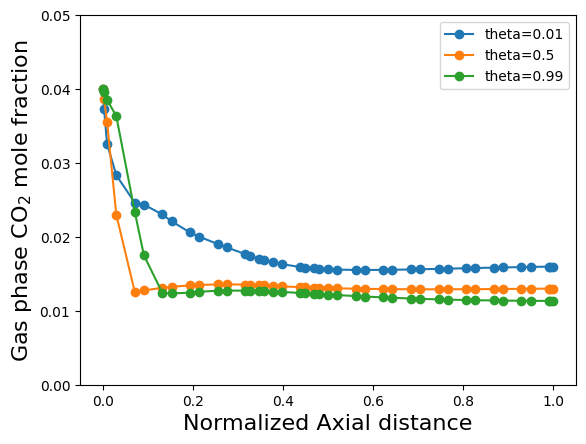

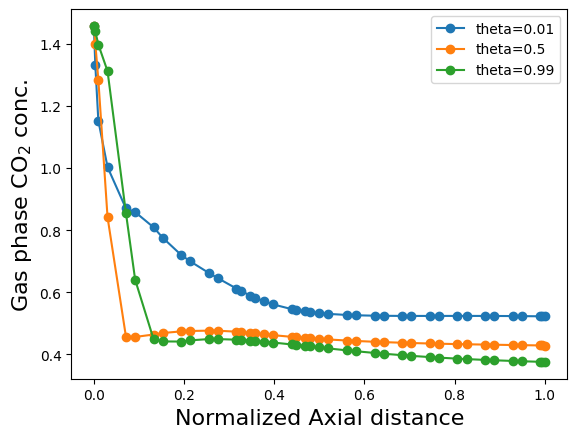

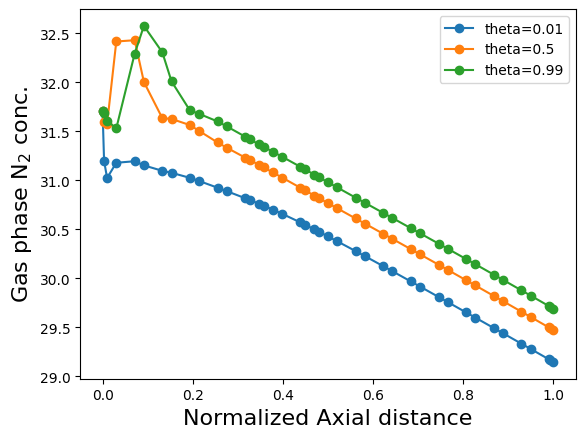

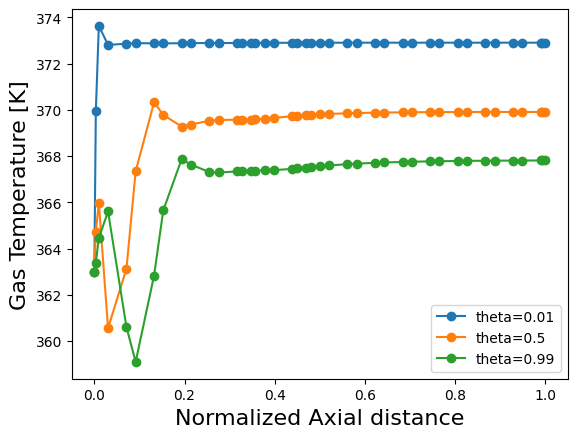

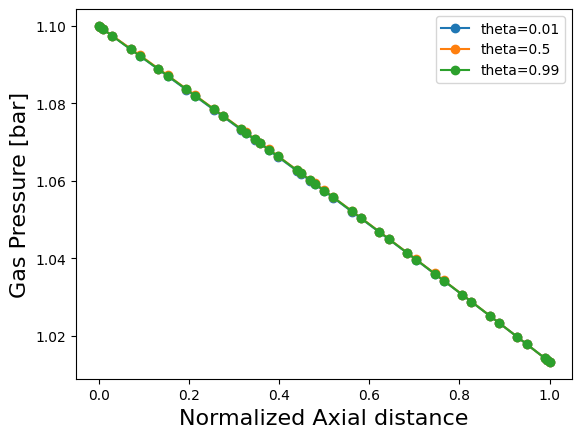

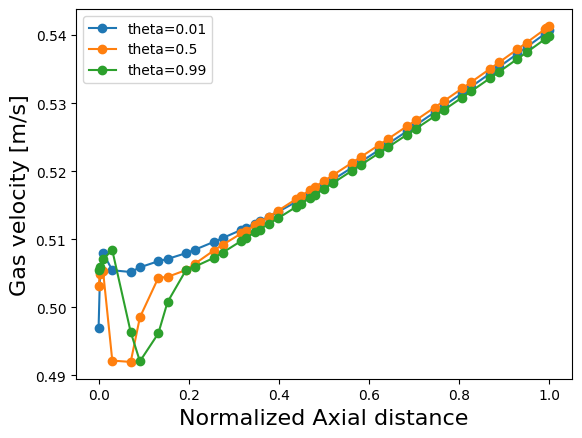

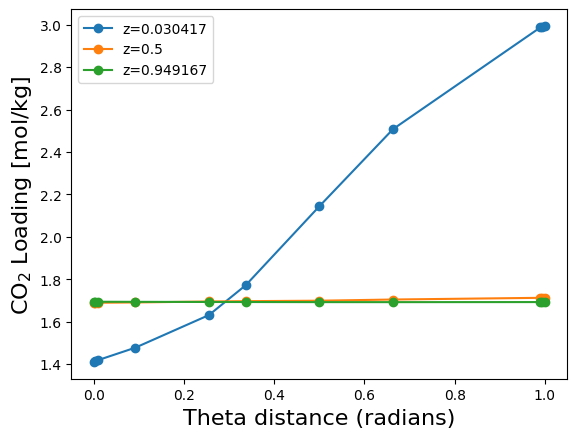

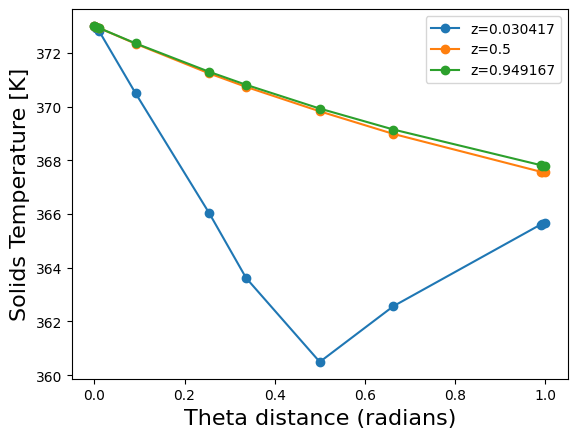

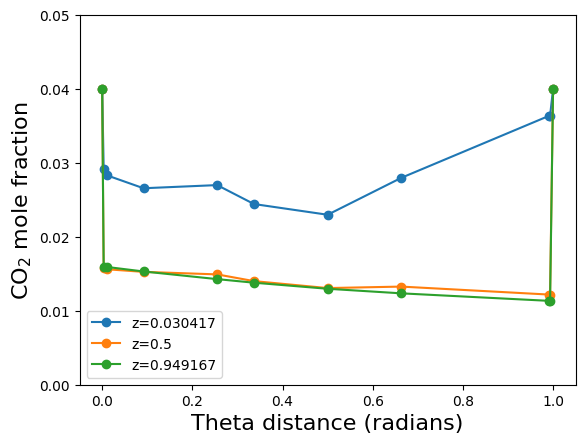

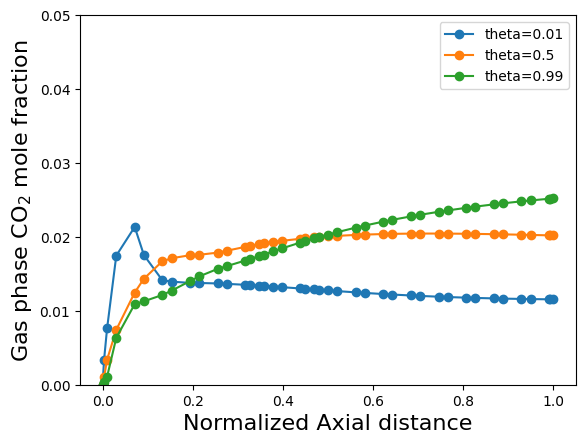

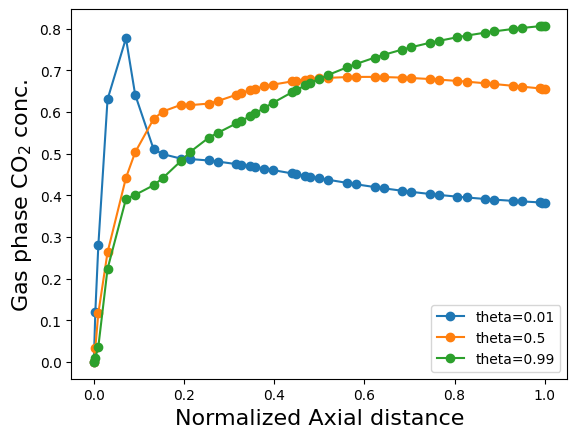

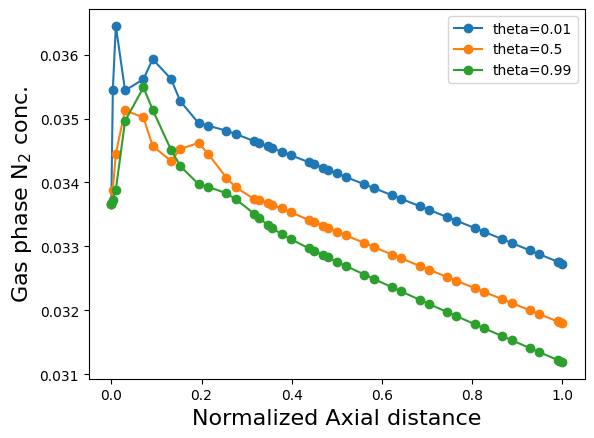

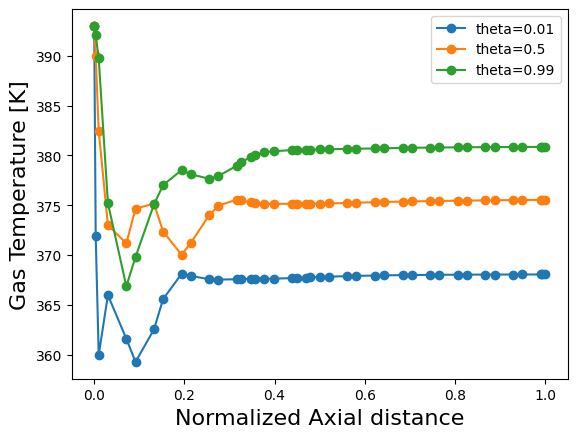

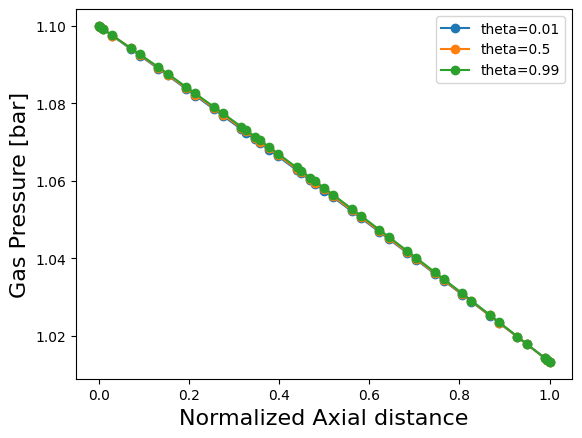

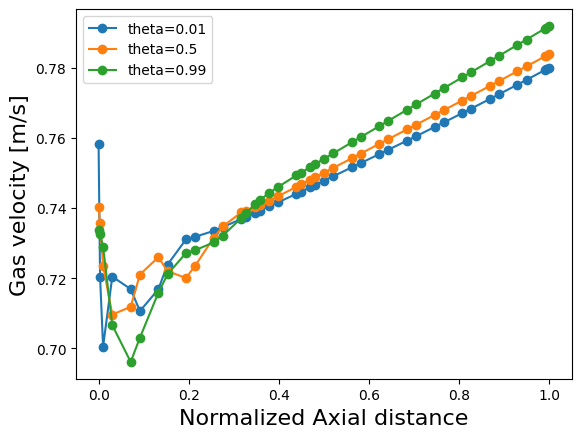

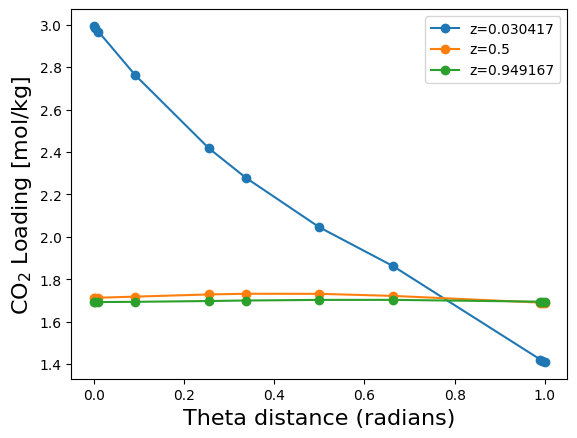

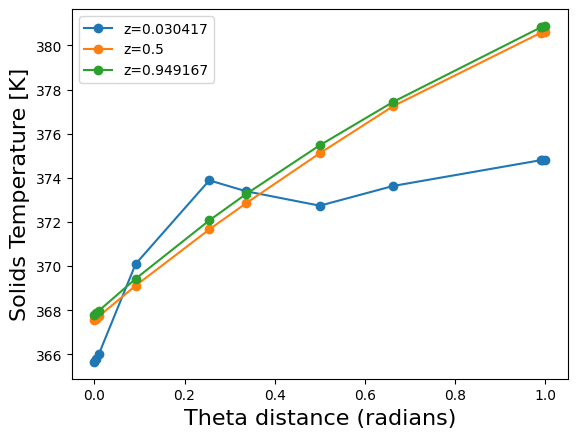

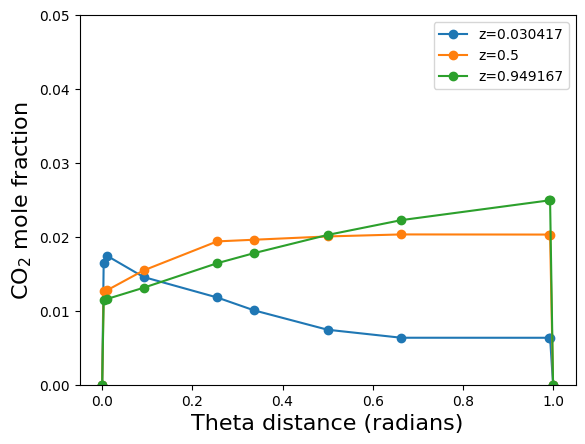

In [13]:
# plotting results

measure_ads = plotting_and_saving(RPB.ads)

# and/or 

measure_des = plotting_and_saving(RPB.des)

In [ ]:
save_to_pickle(measure_ads, "delH_2_upper_ads")
save_to_pickle(measure_des, "delH_2_upper_des")

In [ ]:
print(RPB.ads.o)

In [14]:
#param_list = ["ads.C1", "des.C1",
#             "ads.hgx", "des.hgx",
#             "ads.delH_1", "des.delH_1",
#             "ads.delH_2", "des.delH_2",
#             "ads.delH_3", "des.delH_3"]
 
param_list = ["ads.C1", "des.C1",
             "ads.hgx", "des.hgx",
             "ads.delH_1", "des.delH_1",
             "ads.delH_2", "des.delH_2",
             "ads.delH_3", "des.delH_3"]
    
param_values = [25*1e-3, 25*1e-3]

param = {lis[0]: lis[1] for lis in zip(param_list, param_values)}
print(param)
dsdp, col = get_dsdp(RPB, param_list, param, tee=True)

{'ads.C1': 0.025, 'des.C1': 0.025}
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared.
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]This problem has no degrees of freedom
Pass the option square_override for the desired behaviour
[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/
: dsdp_mode=
dsdp_mode=
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zL_in suffix declared, setting zL = 0.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_in suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dsdp_in_.in
W[K_AUG]...	[K_AUG_ASL]dsdp for linear C(x) + I*p = 0 override.
W[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refineme

In [15]:
dsdp_array = dsdp.toarray().T

#print(col)
kaug_no = col.index('ads.Tg[0.357083,0.336667]')
print(dsdp_array[kaug_no])

[ 5.81637818e+10  1.47142885e+11 -7.30727094e+01  3.01255025e+00
 -2.00466593e-02 -9.90181901e-04  2.03181297e-02 -1.74439211e-03
  5.67415972e-04 -1.52418735e-12]


In [20]:
print(col)

['ads.C_tot[0,0]', 'ads.Tg[0,0]', 'ads.C_tot[0,0.003333]', 'ads.Tg[0,0.003333]', 'ads.C_tot[0,0.01]', 'ads.Tg[0,0.01]', 'ads.C_tot[0,0.091667]', 'ads.Tg[0,0.091667]', 'ads.C_tot[0,0.255]', 'ads.Tg[0,0.255]', 'ads.C_tot[0,0.336667]', 'ads.Tg[0,0.336667]', 'ads.C_tot[0,0.5]', 'ads.Tg[0,0.5]', 'ads.C_tot[0,0.663333]', 'ads.Tg[0,0.663333]', 'ads.C_tot[0,0.99]', 'ads.Tg[0,0.99]', 'ads.C_tot[0,0.993333]', 'ads.Tg[0,0.993333]', 'ads.C_tot[0,1]', 'ads.Tg[0,1]', 'ads.C_tot[0.003333,0]', 'ads.Tg[0.003333,0]', 'ads.C_tot[0.003333,0.003333]', 'ads.Tg[0.003333,0.003333]', 'ads.C_tot[0.003333,0.01]', 'ads.Tg[0.003333,0.01]', 'ads.C_tot[0.003333,0.091667]', 'ads.Tg[0.003333,0.091667]', 'ads.C_tot[0.003333,0.255]', 'ads.Tg[0.003333,0.255]', 'ads.C_tot[0.003333,0.336667]', 'ads.Tg[0.003333,0.336667]', 'ads.C_tot[0.003333,0.5]', 'ads.Tg[0.003333,0.5]', 'ads.C_tot[0.003333,0.663333]', 'ads.Tg[0.003333,0.663333]', 'ads.C_tot[0.003333,0.99]', 'ads.Tg[0.003333,0.99]', 'ads.C_tot[0.003333,0.993333]', 'ads.Tg

In [18]:
test =dsdp_array[kaug_no]

In [19]:
parameter = {
    "DmCO2": 5.3e-5, 
    "C1": 2.562434e-12, 
    "hgx": 25 * 1e-3, 
    "Cp_sol": 1.457, 
    "rho_sol": 1144, 
    "delH_1": 98.76,
    "delH_2": 77.11, 
    "delH_3": 21.25
}

test[0] *= parameter["C1"]
test[1] *= parameter["C1"]
test[2] *= parameter["hgx"]
test[3] *= parameter["hgx"]
test[4] *= parameter["delH_1"]
test[5] *= parameter["delH_1"]
test[6] *= parameter["delH_2"]
test[7] *= parameter["delH_2"]
test[8] *= parameter["delH_3"]
test[9] *= parameter["delH_3"]

print(test)

[ 1.49040852e-01  3.77043932e-01 -1.82681773e+00  7.53137563e-02
 -1.97980808e+00 -9.77903645e-02  1.56673098e+00 -1.34510075e-01
  1.20575894e-02 -3.23889813e-11]
